# **Lab 4. Process images and work with sets of digital image files**

### **Objective:** Gain knowledge and skills in digital image processing using using the Pillow and/or OpenCV libraries and work with a set of of images.

In [3]:
import pandas as pd
import os
import random
import base64
import glob
from PIL import Image
from io import BytesIO
from IPython.display import HTML

#### Task 1. Working with a set of files

Create a function that takes the address of a folder on the disk as an argument and returns a dataframe with the following information about the images located in the folder:
- file name;
- color model;
- format;
- number of channels in the image;
- file size in megabytes bytes rounded to two decimal places;
- width of the picture;
- image height;
- full path to the file;
- thumbnail image.

In [8]:
def get_images_from_dir(folder_path):
    images = []

    for file in glob.glob(f"{folder_path}/*"):
        try:
            images.append(Image.open(file))
        except (IOError, OSError):
            continue

    return images
    

In [5]:
def get_thumbnail(path):
    i = Image.open(path)
    i.thumbnail((150, 150), Image.LANCZOS)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'png')
        return base64.b64encode(buffer.getvalue()).decode()

In [ ]:
def get_image_data(folder_path):
    images = get_images_from_dir(folder_path)
    image_data = []
    
    for img in images:
        image_info = {
            "name": os.path.basename(img.filename),
            "color model": img.mode,
            "format": img.format,
            "channels": len(img.getbands()),
            "size (MB)": round(os.path.getsize(img.filename) / (1024 * 1024), 2),
            "width": img.width,
            "height": img.height,
            "full path": img.filename,
            "image": f'<img src="data:image/png;base64,{image_base64(img.filename)}">'
        }
        image_data.append(image_info)
    
    df = pd.DataFrame(image_data)
    return df

,name,color model,format,channels,size (MB),width,height,full path,image
0,1.jpg,RGB,JPEG,3,0.21,3581,5371,D:\programming\university\year_3\data_python\lab4\images\1.jpg,
1,10.png,RGB,PNG,1,0.88,853,1280,D:\programming\university\year_3\data_python\lab4\images\10.png,
2,11.jpg,RGB,JPEG,3,0.23,850,1280,D:\programming\university\year_3\data_python\lab4\images\11.jpg,
3,12.webp,RGB,WEBP,3,0.75,2594,3891,D:\programming\university\year_3\data_python\lab4\images\12.webp,
4,13.jpg,RGB,JPEG,3,0.29,817,1280,D:\programming\university\year_3\data_python\lab4\images\13.jpg,
5,14.png,RGB,PNG,1,0.43,853,1280,D:\programming\university\year_3\data_python\lab4\images\14.png,
6,15.jpg,RGB,JPEG,3,0.11,853,1280,D:\programming\university\year_3\data_python\lab4\images\15.jpg,
7,2.webp,RGB,WEBP,3,0.79,3953,2224,D:\programming\university\year_3\data_python\lab4\images\2.webp,
8,3.png,RGB,PNG,1,0.79,852,1280,D:\programming\university\year_3\data_python\lab4\images\3.png,
9,4.png,RGB,PNG,1,0.44,853,1280,D:\programming\university\year_3\data_python\lab4\images\4.png,

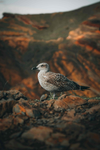
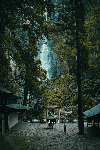
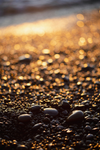
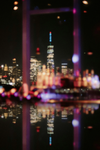
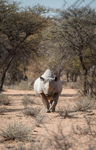
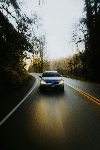
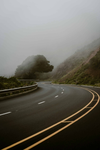
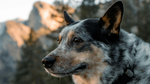
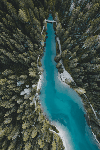
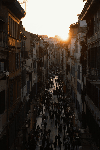
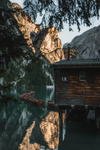
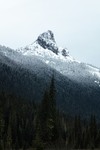
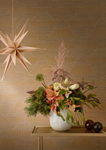
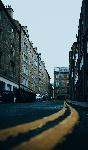
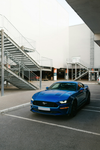

In [15]:
df = get_image_data('./images')
HTML(df.to_html(escape=False))

#### Task 2

Create a function that takes as an argument:
- path to the folder;
- the name of the original image;
- number of images in a row;
- number of images in a column

and returns the image of the poster. We assume that the poster is rectangular and the number of pictures in the poster is a × b, where a is the number of columns and b is the number of rows.

In [6]:
def crop_image_to_square(img):
    size = min(img.size)
    left = (img.width - size) / 2
    top = (img.height - size) / 2
    return img.crop((left, top, img.width - left, img.height - top))
    

In [7]:
def apply_filter(img, filter_color):
    red, green, blue = img.split()
    zero_band = red.point(lambda x: 0)

    if filter_color == "red":
        return Image.merge("RGB", (red, zero_band, zero_band))
    elif filter_color == "green":
        return Image.merge("RGB", (zero_band, green, zero_band))
    elif filter_color == "blue":
        return Image.merge("RGB", (zero_band, zero_band, blue))
    elif filter_color == "yellow":
        return Image.merge("RGB", (red, green, zero_band))
    elif filter_color == "magenta":
        return Image.merge("RGB", (red, zero_band, blue))
    elif filter_color == "cyan":
        return Image.merge("RGB", (zero_band, green, blue))
    else:
        raise ValueError(f"Unsupported filter type: {filter_color}")


In [12]:
def create_poster(folder_path, output_file, rows, cols):
    images = random.choices(get_images_from_dir(folder_path), k=rows * cols)
    color_filters = ["red", "green", "blue", "yellow", "magenta", "cyan"]
    
    item_size = 500
    poster_width = item_size * cols

    poster = Image.new(mode='RGB', size=(cols * item_size, rows * item_size))
    x, y = 0, 0

    for img in images:
        img = crop_image_to_square(img)
        img = img.resize((item_size, item_size)).convert('RGB')
        img = apply_filter(img, random.choice(color_filters))

        poster.paste(img, (x, y))
        
        x += item_size
        
        if x >= poster_width:
            x = 0
            y += item_size
    
    poster.save(os.path.join('posters', output_file))

    return poster

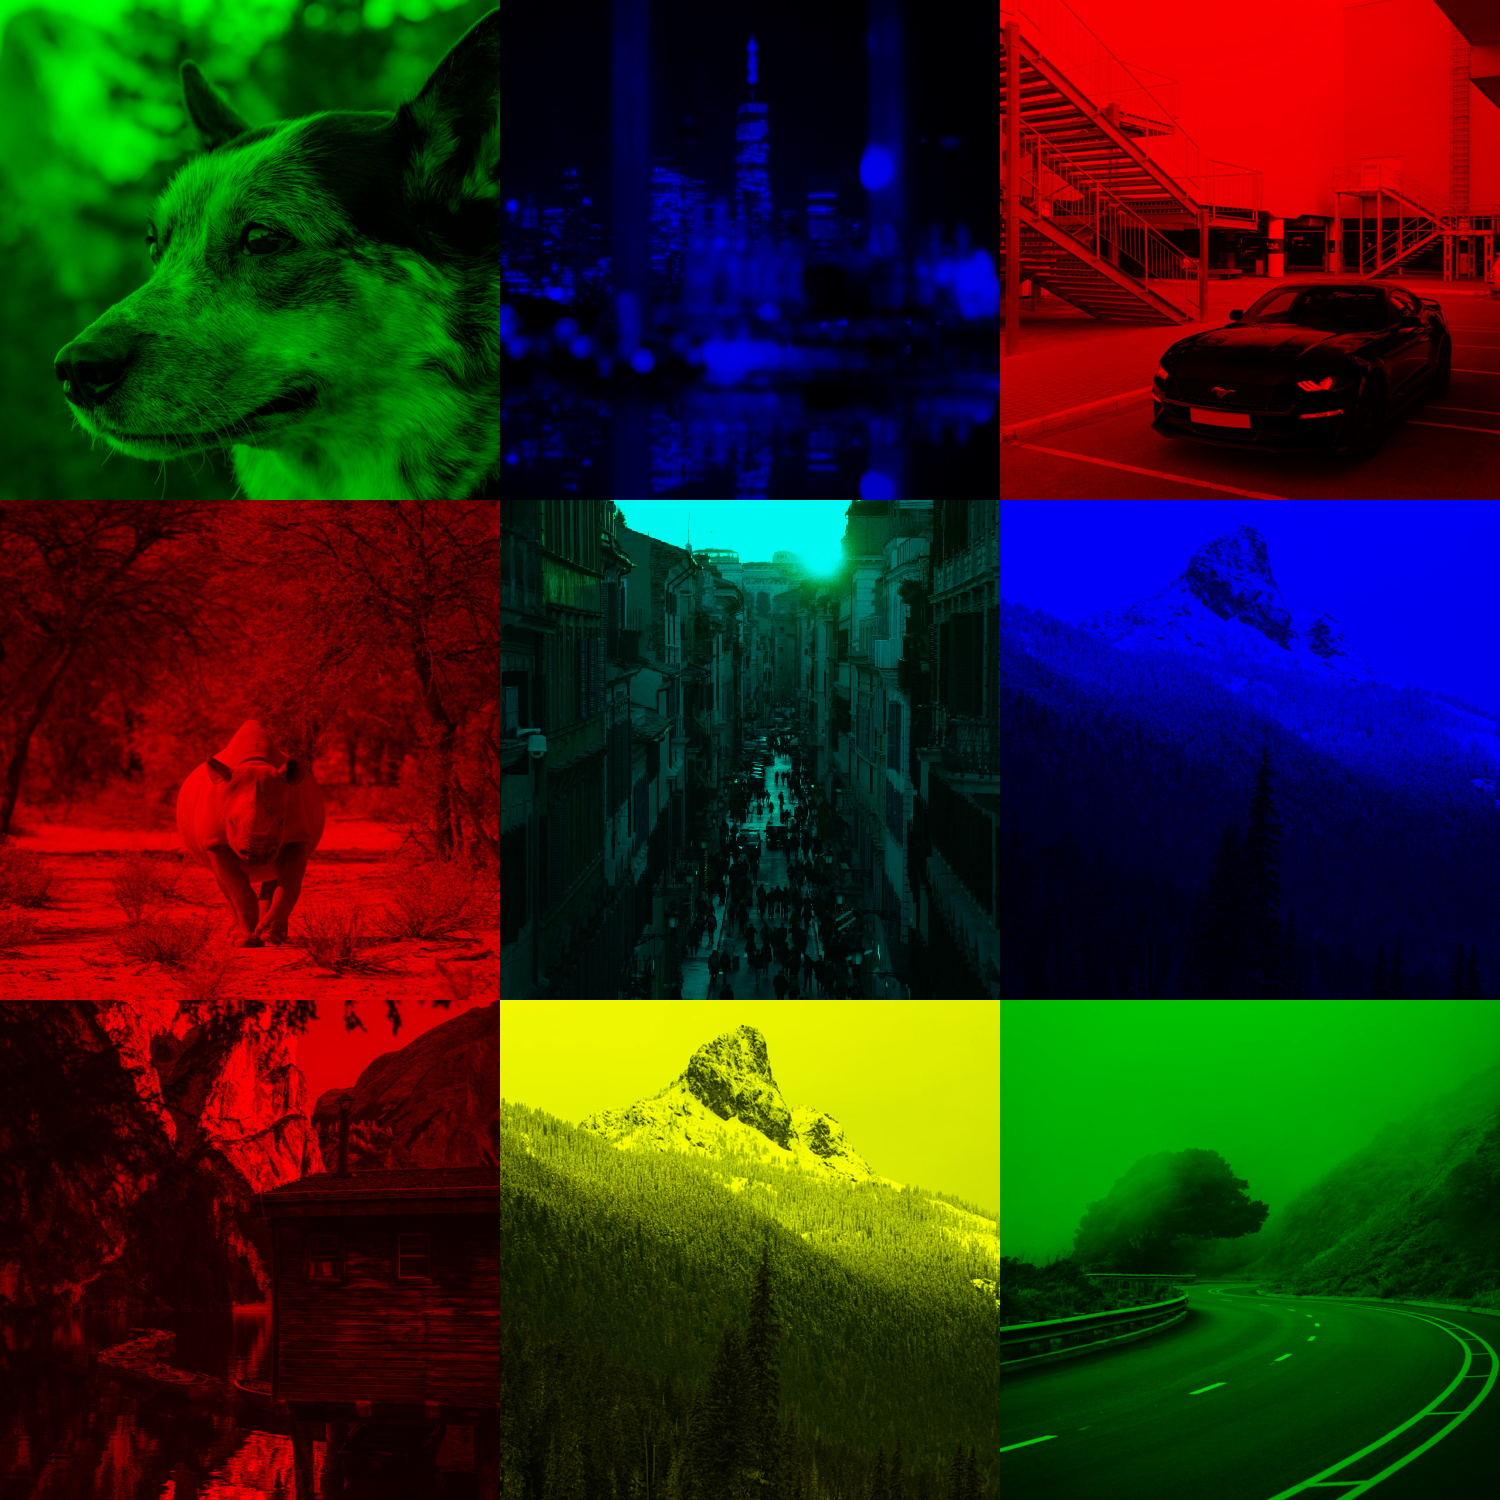

In [16]:
create_poster('./images', 'poster3x3.png', 3, 3)